# Data Project 2 - Machine Learning Application

By Charlie Smith, University of South Alabama, Fall 2023, BUS 798

## 1. Data Selection and Preprocessing
Do a lot of initial work here to get the dataset in order. Much of this work was done in previous assignments.

Skip down to where it says "Machine Learning Application" to see steps 2 through 7 of this assignment.

In [1]:
# Importing pandas for numerical variable analysis and os, numpy, string, and nltk for text variable analysis.

import pandas as pd
import os as os
import numpy as np
import string as string
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')


### 1.2 Reading in Beige Books

In [2]:
# Reading in the Beige Books texts as a dataframe
    # Also including the filename so we can know which region, month, and year it's from

# Setting the directory where the text files of the Beige Books are stored
directory_path = "C:/Users/MCOB PHD 14/Dropbox/Charlie's Dissertation/Beige Books"

# Create empty lists to store text and file names
textDF = []
file_names = []

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
            # Append the text to the text_data list
            textDF.append(file.read())
            # Append the file name to the file_names list
            file_names.append(filename)

# Create a DataFrame from the text and file_names lists
data = {'text': textDF, 'file_name': file_names}
BeigeBookDF = pd.DataFrame(data)

In [3]:
# Import the nltk vader package for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [4]:
BeigeBookDF.head()

,text,file_name
0,"December 9, 1970\nThe economy of the Southeast...",1970_at (1).txt
1,"November 11, 1970\nOur directors report a weak...",1970_at (2).txt
2,"October 14, 1970\nA midsummer business recover...",1970_at (3).txt
3,"September 9, 1970\nThe consensus of directors,...",1970_at (4).txt
4,"August 12, 1970\nThis report is based on a spe...",1970_at (5).txt


In [5]:
# Create the function and run it on the Beige Book dataframe
def analyze_sentiment(BeigeBookDF):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(BeigeBookDF)
    
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        sentiment = 'positive'
    elif compound_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return compound_score, sentiment

BeigeBookDF['compound_score'], BeigeBookDF['sentiment'] = zip(*BeigeBookDF['text'].apply(analyze_sentiment))


### 1.3 DV - Macroeconomic index score

In [6]:
# Reading in the data
districtDiffs = pd.read_csv('district_diffs.csv', encoding='latin1')
districtDiffs.head()

,Date,USPHCI,District 1,District 2,District 3,District 4,District 5,District 6,District 7,District 8,District 9,District 10,District 11,District 12
0,4/1/1979,46.14,0.22,9.92,11.87,16.25,-0.15,-2.42,15.90,11.08,4.86,3.98,-5.66,-5.63
1,5/1/1979,46.37,0.22,9.82,11.79,16.14,-0.24,-2.51,15.80,10.93,4.79,3.90,-5.73,-5.70
2,6/1/1979,46.50,0.30,9.79,11.79,16.09,-0.27,-2.53,15.70,10.83,4.76,3.86,-5.71,-5.65
3,7/1/1979,46.62,0.28,9.66,11.69,15.90,-0.29,-2.62,15.49,10.62,4.65,3.81,-5.67,-5.62
4,8/1/1979,46.68,0.43,9.67,11.62,15.83,-0.32,-2.54,15.23,10.52,4.59,3.83,-5.57,-5.60


In [7]:
# Want to calculate overall mean for the combined districts
# Select the columns you want to include in the mean calculation
district_columns = ['District 1', 'District 2', 'District 3', 'District 4', 'District 5', 'District 6', 'District 7', 'District 8', 'District 9', 'District 10', 'District 11', 'District 12']

# Calculate the overall summary statistics
dv_mean = districtDiffs[district_columns].mean().mean()
dv_median = districtDiffs[district_columns].median().median()
    # Mode omitted because it's not really meaningful to calculate the mode of a continuous variable like this.


# Print the overall mean
print("DV Mean:", dv_mean)
print("DV Median:", dv_median)


DV Mean: 2.0042464040025014
DV Median: 0.985


### 1.4 - Merging datasets

In [8]:
# Changing the Date variable to read as a datetime
districtDiffs['Date'] = pd.to_datetime(districtDiffs['Date'])

In [9]:
# Reshape districtDiffs dataframe from wide to long
districtLong = pd.melt(districtDiffs, id_vars=["Date", "USPHCI"], var_name="District", value_name="Value")

# Extract the numeric part from the "District" names and convert to integers
districtLong["District"] = districtLong["District"].str.extract(r'(\d+)').astype(int)

# Sort the DataFrame by "Date" and "District" columns
districtLong = districtLong.sort_values(by=["Date", "District"])

# Reset the index
districtLong.reset_index(drop=True, inplace=True)

# Display the long-format DataFrame
print(districtLong)


           Date  USPHCI  District  Value
0    1979-04-01   46.14         1   0.22
1    1979-04-01   46.14         2   9.92
2    1979-04-01   46.14         3  11.87
3    1979-04-01   46.14         4  16.25
4    1979-04-01   46.14         5  -0.15
...         ...     ...       ...    ...
6391 2023-08-01  138.76         8  -1.86
6392 2023-08-01  138.76         9   9.02
6393 2023-08-01  138.76        10   7.18
6394 2023-08-01  138.76        11  23.24
6395 2023-08-01  138.76        12  23.50

[6396 rows x 4 columns]


In [10]:
# Define a mapping of city abbreviations to district numbers
city_to_district = {
    "bo": 1,
    "ny": 2,
    "ph": 3,
    "cl": 4,
    "ri": 5,
    "at": 6,
    "ch": 7,
    "sl": 8,
    "mn": 9,
    "kc": 10,
    "da": 11,
    "sf": 12,
}

# Define a mapping of month codes (as named in the original text files of the Beige Books) to month names
month_to_name = {
    "1": "December",
    "2": "October",
    "3": "September",
    "4": "July",
    "5": "June",
    "6": "May",
    "7": "March",
    "8": "January",
}

# Define a mapping of month names to month numbers
name_to_month_numerical = {
    "December": "12",
    "October": "10",
    "September": "09",
    "July": "07",
    "June": "06",
    "May": "05",
    "March": "03",
    "January": "01",
}


In [11]:
# Create a new dataframe that is a copy of BeigeBookDF
bbDF = BeigeBookDF

# Extract the year, city, and month code into separate columns
bbDF[['Year', 'City', 'MonthCode']] = BeigeBookDF['file_name'].str.extract(r'(\d{4})_(\w{2}) \((\d)\).txt')

# Map the city abbreviations to district numbers
bbDF['District'] = bbDF['City'].map(city_to_district)

# Map the month code to month names
bbDF['MonthName'] = bbDF['MonthCode'].map(month_to_name)

# Map the month names to numerical month numbers
bbDF['MonthNumerical'] = bbDF['MonthName'].map(name_to_month_numerical)

# Create a new column with the formatted date
bbDF['Date'] = bbDF['Year'] + '-' + BeigeBookDF['MonthNumerical'] + '-01'

In [12]:
# Convert the 'Date' column to a datetime data type
bbDF['Date'] = pd.to_datetime(bbDF['Date'])

In [13]:
# Use the merge function to join the DataFrames based on the 'Date' and 'District' columns
bbMerged = districtLong.merge(bbDF, on=['Date', 'District'])

# Print the resulting DataFrame
print(bbMerged)


           Date  USPHCI  District  Value  \
0    1979-05-01   46.37         1   0.22   
1    1979-05-01   46.37         2   9.82   
2    1979-05-01   46.37         3  11.79   
3    1979-05-01   46.37         4  16.14   
4    1979-05-01   46.37         5  -0.24   
...         ...     ...       ...    ...   
4249 2023-07-01  138.66         8  -1.73   
4250 2023-07-01  138.66         9   9.13   
4251 2023-07-01  138.66        10   7.26   
4252 2023-07-01  138.66        11  23.03   
4253 2023-07-01  138.66        12  23.27   

                                                   text        file_name  \
0      May 16, 1979\nBusiness activity in the First ...  1979_bo (6).txt   
1      May 16, 1979 \nSecond District business activ...  1979_ny (6).txt   
2      May 16, 1979 \nThird District economic activi...  1979_ph (6).txt   
3      May 16, 1979 \nManufacturing activity in the ...  1979_cl (6).txt   
4      May 16, 1979 \nMost indications are that Fift...  1979_ri (6).txt   
...            

In [14]:
# Going to rename the Value column and drop the 'FormattedDate' column

bbMerged = bbMerged.rename(columns={'Value': 'econ_index'})

In [15]:
# Going to calculate the average score by date

# Group the DataFrame by "Date" and calculate the mean for each group

grouped_data = bbMerged.groupby('District')['econ_index'].describe()
print(grouped_data)

          count      mean       std    min     25%    50%      75%    max
District                                                                 
1         353.0  1.985694  5.122485 -12.24 -0.8500  0.320   3.1900  18.48
2         355.0  2.531239  5.238412 -20.98 -0.8400  0.800   8.1200  11.54
3         354.0  2.201130  6.234531 -18.44 -3.0700  1.820   7.7125  11.79
4         355.0  3.902310  6.693100 -15.99 -2.2800  4.960  10.0350  16.14
5         355.0  0.839493  3.389718  -3.15 -1.2200 -0.480   1.5000  11.58
6         355.0  0.077239  4.755397  -3.99 -2.7900 -2.220   0.5500  14.65
7         355.0  3.876563  6.586542 -19.63 -2.3550  4.750  10.0350  15.80
8         354.0  3.028051  3.775910  -6.99 -0.5300  2.115   6.5200  10.93
9         355.0  2.672930  3.044462  -8.35  0.7700  1.950   3.9600  12.11
10        354.0  1.824294  2.505323  -1.82 -0.3275  1.175   3.6900   8.69
11        355.0  1.425915  8.723021  -8.00 -5.0200 -3.040   9.2250  23.03
12        354.0 -0.337542  8.526031  -

In [16]:
from nltk.tokenize import sent_tokenize, word_tokenize

### 1.5 Cosine Similarity and PageRank approach
This is related to working toward identifying key phrases within the texts that help predict economic outcomes.

I didn't end up using this section now but am leaving it in because I might come back to it in the future.

In [17]:
### Create tokenized sentences
bbMerged['sentences'] = bbMerged['text'].apply(nltk.sent_tokenize)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Sample DataFrame with tokenized sentences in 'sentences' column
# bbMerged = ...

# Step 1: Preprocess sentences (e.g., using NLTK for tokenization)
# Assuming you have already done the preprocessing and tokenization

# Step 2: Vectorize sentences using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(bbMerged['sentences'].apply(lambda x: ' '.join(x)))

# Step 3: Calculate the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a DataFrame from the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, columns=bbMerged.index, index=bbMerged.index)

# Now, cosine_sim_df contains the cosine similarity scores between each pair of sentences.


In [19]:
import networkx as nx
import numpy as np

# Create a graph with sentences as nodes and cosine similarity scores as edges
G = nx.Graph()
num_sentences = len(bbMerged)

for i in range(num_sentences):
    for j in range(i + 1, num_sentences):
        similarity = cosine_sim_matrix[i][j]
        if similarity > 0.0:  # You may choose a threshold to include only relevant edges
            G.add_edge(i, j, weight=similarity)

# Calculate PageRank scores
page_rank_scores = nx.pagerank(G, weight='weight')

# Sort sentences by PageRank score (importance)
sorted_sentences = sorted(page_rank_scores.items(), key=lambda x: x[1], reverse=True)

# Extract the most important sentences
num_top_sentences = 5  # You can change this value as needed
top_sentence_indices = [index for index, score in sorted_sentences[:num_top_sentences]]

# Get the actual sentences from the DataFrame
top_sentences = [bbMerged['sentences'][index] for index in top_sentence_indices]

# Now, top_sentences contains the most important sentences based on PageRank scores.


### 1.6 Keyword Extraction approach

Calculate the most important trigrams (three-word phrases) in the corpus using a Term Frequency-Inverse Document Frequency approach.

The goal is to create an independent variable that includes the sentiment in sentences immediately surrounding these key phrases.

In [20]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [21]:
# Going to prepare the text for analysis by ...
    # Tokenizing
    # Converting to lowercase
    # Removing punctuation
    # Removing stopwords (common words like 'the' 'and' 'to' etc.)
# bbMerged = ...

# Step 1: Tokenization
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Step 2: Lowercasing
def lowercase_text(tokens):
    return [token.lower() for token in tokens]

# Step 3: Removing Punctuation
def remove_punctuation(tokens):
    table = str.maketrans('', '', string.punctuation)
    return [token.translate(table) for token in tokens]

# Step 4: Removing Stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Apply preprocessing steps to the 'text' column in the DataFrame
bbMerged['preprocessed_text'] = bbMerged['text'].apply(tokenize_text)
bbMerged['preprocessed_text'] = bbMerged['preprocessed_text'].apply(lowercase_text)
bbMerged['preprocessed_text'] = bbMerged['preprocessed_text'].apply(remove_punctuation)
bbMerged['preprocessed_text'] = bbMerged['preprocessed_text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to C:\Users\MCOB PHD
[nltk_data]     14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text to obtain TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(bbMerged['preprocessed_text'].apply(' '.join))

# Now, tfidf_matrix contains the TF-IDF vectors for the preprocessed text in your DataFrame.

# If you want to see the feature names (terms) corresponding to the columns of the TF-IDF matrix, you can do:
feature_names = tfidf_vectorizer.get_feature_names_out()

# You can also create a DataFrame from the TF-IDF matrix to inspect the TF-IDF values:
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# The 'tfidf_df' DataFrame contains the TF-IDF values for each term in each document.


In [23]:
# Doing trigrams
    # Change the range, for example, to (1, 3) if want to do single words, two-word phrases, and three-word phrases
    # In this case, three may be best

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer with your chosen n-gram range
ngram_range = (3, 3)  # Example: Use unigrams and bigrams and trigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range)

# Fit and transform the preprocessed text to obtain TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(bbMerged['preprocessed_text'].apply(' '.join))

# Now, tfidf_matrix contains the TF-IDF vectors with the specified n-grams.


In [24]:
# Get the feature names (terms) corresponding to the columns of the TF-IDF matrix
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the TF-IDF scores for each feature
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # A1 converts the result to a 1-D array

# Create a DataFrame to represent features and their TF-IDF scores
tfidf_df = pd.DataFrame({'feature': feature_names, 'tfidf_score': tfidf_scores})

# Sort the features by TF-IDF scores in descending order to identify the most important features
top_features = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Now, 'top_features' contains the most important trigrams based on TF-IDF scores.

In [25]:
tfidf_df

,feature,tfidf_score
0,000 barrels per,0.039697
1,007 percentage points,0.045291
2,01 2017 summary,0.374594
3,01 percent 11,0.043780
4,01 percent 63,0.043780
...,...,...
1840459,zooming along financial,0.043610
1840460,zoos botanical gardens,0.044615
1840461,â½ point led,0.038300
1840462,â½ point september,0.038425


In [26]:
# These are the top 100 phrases, and I export them to a CSV file to review in Excel.

top_100_features = top_features.head(100)

# Save the extracted DataFrame to a CSV file
#top_100_features.to_csv('top_100_features.csv', index=False)

In [27]:
top_100_features

,feature,tfidf_score
261596,commercial real estate,35.247748
1552197,since last report,33.760136
1064238,new york city,24.196232
1406965,residential real estate,23.296537
1552766,since previous report,21.637545
...,...,...
1426575,retail trade services,4.892598
54451,activity third district,4.836184
1158947,past three months,4.817717
1695522,third district banks,4.743864


### 1.7 Mean Compound Score

Instead of a compound score for the whole document, which tends toward extremes of -1 and 1, I calculate the score for each sentence in each document.

This allows for some flexibility in calculating different distributions (quartiles and deciles) of the sentence scores within each Beige Book.

In [28]:
import os
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


In [29]:
sia = SentimentIntensityAnalyzer()

def calculate_sentiment_scores(text):
    sentences = sent_tokenize(text)
    scores = []

    for sentence in sentences:
        sentiment_score = sia.polarity_scores(sentence)
        scores.append(sentiment_score)

    return scores


In [30]:
results = []

In [31]:
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):  # Assuming your text files have a .txt extension
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r') as file:
            text = file.read()
        
        sentiment_scores = calculate_sentiment_scores(text)
        results.append({
            'File': filename,
            'Sentiment Scores': sentiment_scores
        })


In [32]:
# Going to do the above for every document
    # Going to start with the bbMerged file, which already has Beige Book documents listed by city and date
    # Going to create a new df that drops some of the extra stuff leftover in bbMerged

bbSimple = bbMerged
bbSimple.drop('sentiment', axis=1, inplace=True)
bbSimple.drop('file_name', axis=1, inplace=True)
bbSimple.drop('MonthCode', axis=1, inplace=True)

In [33]:
# Now calculating the compound score for each sentence in each Beige Book
    # Then saving that as a list within the bbSimple dataframe

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate the compound sentiment score
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    compound_scores = [sid.polarity_scores(sentence)['compound'] for sentence in sentences]
    return compound_scores

# Assuming 'bbSimple' is your DataFrame
bbSimple['compound_sentiment'] = bbSimple['text'].apply(calculate_sentiment)


In [34]:
# Example: Calculate the mean and median sentiment scores for each document
# bbSimple['mean_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
# bbSimple['median_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sorted(x)[len(x) // 2] if len(x) > 0 else 0)

bbSimple['mean_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
bbSimple['median_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sorted(x)[len(x) // 2] if len(x) > 0 else 0)

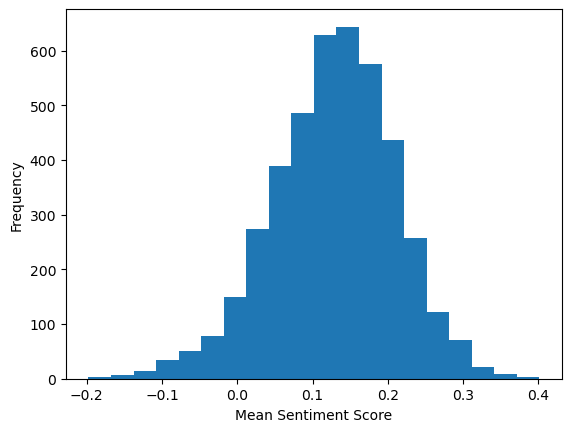

In [35]:
import matplotlib.pyplot as plt
# Example: Create a histogram of compound sentiment scores
plt.hist(bbSimple['mean_sentiment'], bins=20)
plt.xlabel('Mean Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [36]:
# Calculate deciles

import numpy as np

# Define a list of desired deciles (10th, 20th, ..., 90th percentiles)
deciles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Calculate the specified deciles for each document
for decile in deciles:
    column_name = f'{decile}th_decile_sentiment'
    bbSimple[column_name] = bbSimple['compound_sentiment'].apply(lambda x: np.percentile(x, decile) if len(x) > 0 else 0)


In [37]:
# Doing quartiles as well

import numpy as np

# DbbSimple[['econ_index', 'compound_sentiment', 'mean_sentiment', 'IQR_sentiment']].median()efine a list of desired quartiles (25th, 50th, and 75th percentiles)
quartiles = [25, 50, 75]

# Calculate the specified quartiles for each document
for quartile in quartiles:
    column_name = f'{quartile}th_quartile_sentiment'
    bbSimple[column_name] = bbSimple['compound_sentiment'].apply(lambda x: np.percentile(x, quartile) if len(x) > 0 else 0)


### 1.8 Economic Index Dummy

To set up for a classification model, a dummy is created that equals 1 for positive values of the economic index (DV) and 0 for non-positive values.

A 1 indicates a district has a more positive sentiment that month than the national average.

In [38]:
# Create a new column 'econ_index_dummy' and set it to 1 for positive values and 0 for non-positive values
bbSimple['econ_index_dummy'] = bbSimple['econ_index'].apply(lambda x: 1 if x > 0 else 0)


### 1.9 Interquartile Range

Interquartile range gives a measure of the variation in the sentence sentiment scores within a document.

This is an IV in the model.

In [39]:
# Calculating interquartile range
bbSimple['IQR_sentiment'] = bbSimple['75th_quartile_sentiment'] - bbSimple['25th_quartile_sentiment']

# Machine learning application

## 2. Train/Test Split

In [40]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with an 80/20 ratio
train_set, test_set = train_test_split(bbSimple, test_size=0.2, random_state=7)

# 'test_size' specifies the proportion of the dataset to include in the test split (0.2 means 20%)
# 'random_state' is used to ensure reproducibility, you can set it to any integer value for consistency

# You can now use 'train_set' and 'test_set' for your machine learning tasks


In [41]:
# Assuming 'target_column' is the name of the column you want to predict
X_train = train_set.drop(columns=['econ_index_dummy'])
y_train = train_set['econ_index_dummy']

X_test = test_set.drop(columns=['econ_index_dummy'])
y_test = test_set['econ_index_dummy']


In [42]:
X_train = X_train[['mean_sentiment', 'IQR_sentiment']]
X_test = X_test[['mean_sentiment', 'IQR_sentiment']]


## 3. Model Selection

Going to use a random forest to classify whether the economic index for a given month is positive (greater than the national index) or negative (less than the national index).

Random forest is an appropriate method for a classification problem like this. However, you could use the economic index score, rather than the dummy, and use a regression setup.

Classification was used because the interpretation of the results was more straightforward in this case: What percentage of cases were predicted correctly?

In [43]:
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression

# Create a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=7)  # You can adjust hyperparameters as needed

## 4. Model Training

In [44]:
# Train the model on the training data
model.fit(X_train, y_train)


RandomForestClassifier(random_state=7)

In [45]:
# Make predictions on the test data
predictions = model.predict(X_test)


In [46]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# For 80/20 test/train split
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)


In [47]:
print("Accuracy:", accuracy)
print("F1:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.5229142185663925
F1: 0.5744234800838575
Recall: 0.5956521739130435
Precision: 0.5546558704453441


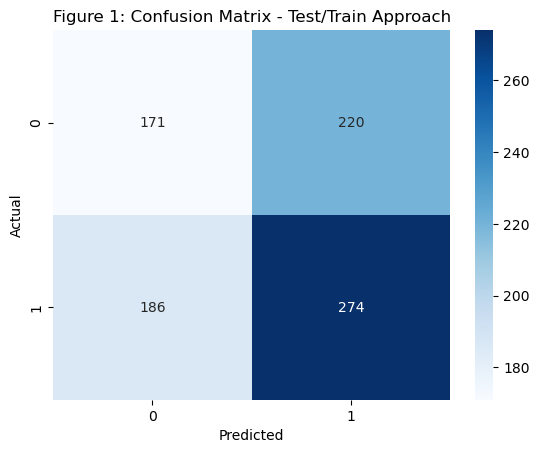

In [48]:
import seaborn as sns
conf_matrix_test_train = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix_test_train, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 1: Confusion Matrix - Test/Train Approach")
#plt.savefig("confusion_matrix_testtrain.png")
plt.show()


### 4.2 - 5-fold cross validation

In [49]:
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression
from sklearn.model_selection import cross_val_predict, KFold

In [50]:
# Preparing data
X = bbSimple[['mean_sentiment', 'median_sentiment', 'IQR_sentiment']]  # Specify your features here
y = bbSimple['econ_index_dummy']


In [51]:
model = RandomForestClassifier(n_estimators=100, random_state=7)  # You can adjust hyperparameters as needed


In [52]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Create a 5-fold cross-validation split

# Perform cross-validation and get predictions
predictions = cross_val_predict(model, X, y, cv=kf)


## 5. Model Evaluation

In [53]:
# Evaluate the model's performance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # Use appropriate metrics for your problem

accuracy = accuracy_score(y, predictions)
f1 = f1_score(y, predictions)
precision = precision_score(y, predictions)
recall = recall_score(y, predictions)


In [54]:
print("Accuracy:", accuracy)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5314997649271274
F1: 0.5908437692465612
Precision: 0.5687747035573123
Recall: 0.6146945749679624


In [55]:
from sklearn.metrics import classification_report  # Use appropriate metrics for your problem

class_report = classification_report(y, predictions)
print(f'Classification Report:\n{class_report}')


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.43      0.45      1913
           1       0.57      0.61      0.59      2341

    accuracy                           0.53      4254
   macro avg       0.52      0.52      0.52      4254
weighted avg       0.53      0.53      0.53      4254



### 5.2 Cross-validation metric scores

In [56]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and obtain metric scores (e.g., accuracy)
cv_scores = cross_val_score(model, X, y, cv=5)  # cv=5 means 5-fold cross-validation

# Print the cross-validated metric scores
print("Cross-validated Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-validated Accuracy Scores: [0.49706228 0.49588719 0.54876616 0.57109283 0.51058824]
Mean Accuracy: 0.5246793391857331


## 6. Results Visualization

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [58]:
# Compute the Confusion Matrix:
conf_matrix_kfold = confusion_matrix(y, predictions)


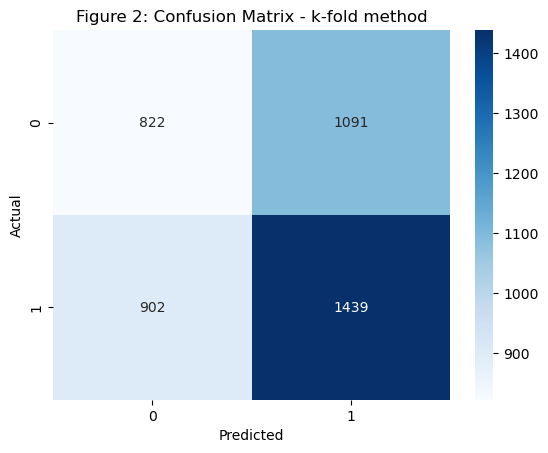

In [59]:
sns.heatmap(conf_matrix_kfold, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 2: Confusion Matrix - k-fold method")
#plt.savefig("confusion_matrix_kfold.png")
plt.show()


### 6.2 - Feature importance plot
Want to show how much each predictor mattered.

In [60]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# Previously defined 'X' and 'y' and 'kf' for 5-fold cross-validation
# Create an empty list to store feature importances for each fold
feature_importances_list = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Create and train a Random Forest model for this fold
    model = RandomForestClassifier(n_estimators=100, random_state=7)
    model.fit(X_train, y_train)
    
    # Retrieve and store feature importances for this fold
    feature_importances_list.append(model.feature_importances_)


In [62]:
import numpy as np

# Calculate the mean feature importances across all folds
mean_feature_importances = np.mean(feature_importances_list, axis=0)

# Create a DataFrame with feature names and their mean importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [63]:
feature_importance_df.head()

,Feature,Importance
0,mean_sentiment,0.517033
2,IQR_sentiment,0.386779
1,median_sentiment,0.096188


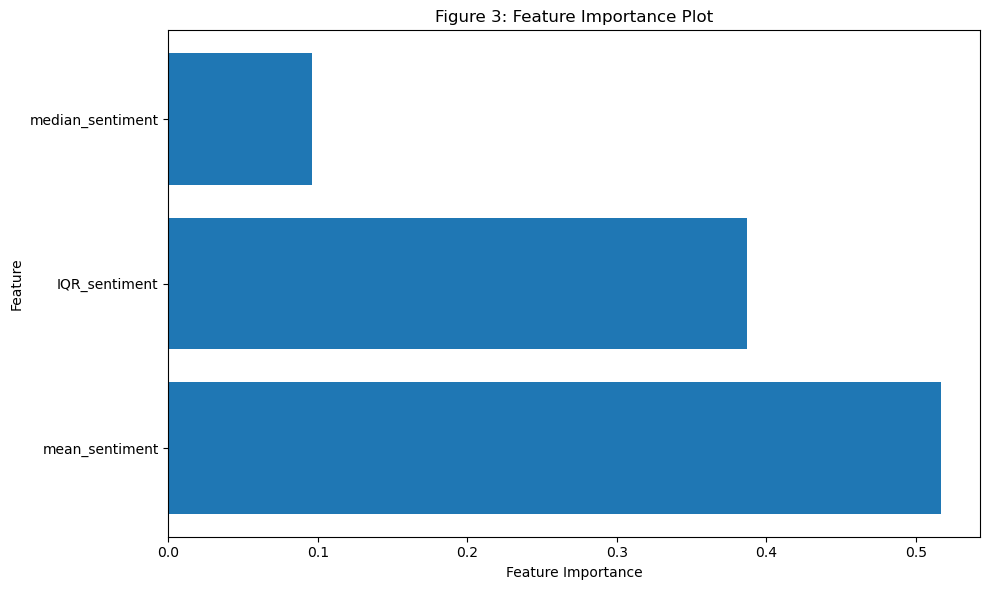

In [64]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot for feature importances
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])

# Customize the plot
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Figure 3: Feature Importance Plot')
plt.tight_layout()
# Save the plot
#plt.savefig("feature_importance.png")

# Show the plot
plt.show()


## 7. Interpretation of Results

The model's accuracy is not good; it only correctly predicts whether the economic index is greater or worse than the national average 53.7% of the time. Those results are only marginally better than a guess.

However, I expected that with the limited number of variables. Mean sentiment is the most important predictor, followed by interquartile range of the sentiment. Median sentiment does not add much predictive power to the model.

My future plan is to improve the model's predictions by adding more predictor variables, namely related to the presence of key trigrams in the document.



# Creating trigrams

In [65]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

trigrams = pd.read_csv("trigrams.csv")

In [66]:
# Assuming trigrams is a DataFrame with a column named "trigram"
# and bbSimple is a DataFrame with columns "text", "Date", "District", "Year", "City"

# Load NLTK's sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment for a given text
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    compound_score = 0

    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        compound_score += scores['compound']

    average_compound_score = compound_score / len(sentences)
    return average_compound_score

# List to store trigram and sentiment information
trigram_sentiment_list = []


# Loop through each trigram
for _, trigram_row in trigrams.iterrows():
    trigram = trigram_row['trigram']

    # Loop through each document in the subset
    for _, doc_row in bbSimple.iterrows():
        document = doc_row['text']
        date = doc_row['Date']
        district = doc_row['District']
        year = doc_row['Year']
        city = doc_row['City']
        month = doc_row['MonthName']

        # Tokenize the document into sentences
        sentences = sent_tokenize(document)

        # Check if the trigram is present in any sentence
        for sentence_index, sentence in enumerate(sentences):
            if trigram in sentence:
                # Extract the surrounding two sentences
                trigram_index = sentence_index
                start_index = max(0, trigram_index - 1)
                end_index = min(len(sentences), trigram_index + 2)
                context_sentences = sentences[start_index:end_index]

                # Join the sentences to form a paragraph
                context_paragraph = ' '.join(context_sentences)

                # Calculate sentiment for the extracted context
                sentiment_score = calculate_sentiment(context_paragraph)

                # Append trigram, sentiment, and context to the list
                trigram_sentiment_list.append({
                    'Trigram': trigram,
                    'Sentiment': sentiment_score,
                    'Context': context_paragraph,
                    'Document': document,
                    'Date': date,
                    'District': district,
                    'Year': year,
                    'City': city,
                    'Month': month
                })

# Create a DataFrame from the list of dictionaries
result_df3 = pd.DataFrame(trigram_sentiment_list)

# Display the DataFrame
print(result_df3)

# Export the DataFrame to a CSV file in the default working directory
#result_df3.to_csv('trigram_sentiment_results.csv', index=False)

# Display a message indicating the export is successful
#print('DataFrame successfully exported to trigram_sentiment_results.csv in the default working directory.')


                      Trigram  Sentiment  \
0      commercial real estate   0.265633   
1      commercial real estate   0.163100   
2      commercial real estate   0.293600   
3      commercial real estate   0.340300   
4      commercial real estate   0.018567   
...                       ...        ...   
14712     tight labor markets  -0.089200   
14713     tight labor markets   0.525067   
14714     tight labor markets   0.350767   
14715     tight labor markets   0.474833   
14716     tight labor markets  -0.261500   

                                                 Context  \
0      Some \nprojects that would normally be finance...   
1      Banking Developments\n Loan demand is mixed at...   
2      Commercial and industrial lending is strong \n...   
3      S&L rates \non MMDA and Super NOW accounts are...   
4      In recent weeks \nsome signs have emerged that...   
...                                                  ...   
14712  Hotels and restaurants, in particular, conti

In [65]:
# Group by 'Trigram' and calculate summary statistics
summary_stats = result_df3.groupby('Trigram').describe()

# Display the summary statistics
print(summary_stats)


                                  Sentiment                                \
                                      count      mean       std       min   
Trigram                                                                     
auto dealers reported                 137.0  0.159793  0.223637 -0.362967   
business loan demand                  161.0  0.142782  0.242183 -0.630900   
capital spending plans                327.0  0.143254  0.221628 -0.534200   
commercial construction activity      110.0  0.125422  0.204761 -0.486400   
commercial real estate               2719.0  0.157698  0.213211 -0.695000   
construction real estate                1.0  0.190633       NaN  0.190633   
consumer loan demand                  168.0  0.112396  0.213594 -0.575233   
district manufacturing activity         2.0  0.200117  0.303514 -0.014500   
existing home sales                   223.0  0.159497  0.220989 -0.422333   
higher interest rates                 325.0  0.220749  0.221111 -0.683467   

In [67]:
bbSimple

,Date,USPHCI,District,econ_index,text,compound_score,Year,City,MonthName,MonthNumerical,...,50th_decile_sentiment,60th_decile_sentiment,70th_decile_sentiment,80th_decile_sentiment,90th_decile_sentiment,25th_quartile_sentiment,50th_quartile_sentiment,75th_quartile_sentiment,econ_index_dummy,IQR_sentiment
0,1979-05-01,46.37,1,0.22,"May 16, 1979\nBusiness activity in the First ...",0.8284,1979,bo,May,05,...,0.00000,0.21472,0.38582,0.53680,0.64602,-0.0258,0.00000,0.401900,1,0.427700
1,1979-05-01,46.37,2,9.82,"May 16, 1979 \nSecond District business activ...",0.9868,1979,ny,May,05,...,0.17610,0.27320,0.34000,0.42150,0.55420,0.0000,0.17610,0.371500,1,0.371500
2,1979-05-01,46.37,3,11.79,"May 16, 1979 \nThird District economic activi...",0.9954,1979,ph,May,05,...,0.00000,0.11406,0.31820,0.39990,0.57485,0.0000,0.00000,0.371350,1,0.371350
3,1979-05-01,46.37,4,16.14,"May 16, 1979 \nManufacturing activity in the ...",0.3092,1979,cl,May,05,...,0.00000,0.00000,0.10100,0.30932,0.39371,-0.2291,0.00000,0.204500,1,0.433600
4,1979-05-01,46.37,5,-0.24,"May 16, 1979 \nMost indications are that Fift...",0.9954,1979,ri,May,05,...,0.08570,0.27320,0.45880,0.54230,0.70960,-0.0387,0.08570,0.502250,0,0.540950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249,2023-07-01,138.66,8,-1.73,"July 12, 2023\n\nSummary of Economic Activity\...",0.9959,2023,sl,July,07,...,0.00000,0.11526,0.27320,0.36120,0.51312,-0.1280,0.00000,0.273200,0,0.401200
4250,2023-07-01,138.66,9,9.13,"July 12, 2023\n\nSummary of Economic Activity\...",0.9991,2023,mn,July,07,...,0.00000,0.27320,0.37562,0.54076,0.60835,0.0000,0.00000,0.458800,1,0.458800
4251,2023-07-01,138.66,10,7.26,"July 12, 2023\n\nSummary of Economic Activity\...",0.9988,2023,kc,July,07,...,0.23775,0.32654,0.38180,0.47826,0.62050,0.0000,0.23775,0.396875,1,0.396875
4252,2023-07-01,138.66,11,23.03,"July 12, 2023\n\nSummary of Economic Activity\...",0.9957,2023,da,July,07,...,0.01290,0.23558,0.31820,0.38984,0.47670,0.0000,0.01290,0.355900,1,0.355900


In [66]:
# Mean of each trigram's sentiment + all other trigrams' sentiment found in a document
    # Some documents don't have any Trigrams; some have multiple
mean_sentiments = result_df3.groupby(['Document'])['Sentiment'].mean().reset_index()


In [67]:
mean_sentiments2 = result_df3.groupby(['Document', 'Context'])['Sentiment'].mean().reset_index()

In [68]:
mean_sentiments2.describe()

,Sentiment
count,10780.000000
mean,0.160859
std,0.213397
min,-0.695000
25%,0.010400
50%,0.164633
75%,0.309400
max,0.808600


In [69]:
# Rename the 'Sentiment' column to 'Sentiment_Trigram'
mean_sentiments = mean_sentiments.rename(columns={'Sentiment': 'sentiment_trigram'})


In [70]:
# Merge mean_sentiments back to bbSimple based on the common columns 'text' and 'Document'
bbTri = pd.merge(bbSimple, mean_sentiments, left_on='text', right_on='Document', how='left')

# Drop the duplicate 'Document' column, which is now redundant
bbTri = bbTri.drop('Document', axis=1)

In [82]:
bbTri['sentiment_trigram'] = bbTri['sentiment_trigram'].fillna(0)

In [89]:
bbTri.describe()

,USPHCI,District,econ_index,mean_sentiment,median_sentiment,10th_decile_sentiment,20th_decile_sentiment,30th_decile_sentiment,40th_decile_sentiment,50th_decile_sentiment,60th_decile_sentiment,70th_decile_sentiment,80th_decile_sentiment,90th_decile_sentiment,25th_quartile_sentiment,50th_quartile_sentiment,75th_quartile_sentiment,econ_index_dummy,IQR_sentiment,sentiment_trigram
count,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000
mean,85.881443,6.500943,1.989022,0.127853,0.089875,-0.299687,-0.118792,-0.028262,0.014729,0.085321,0.200253,0.322246,0.438618,0.572135,-0.063031,0.085321,0.380590,0.550212,0.443621,0.123576
std,25.915295,3.450888,5.834020,0.081771,0.120031,0.147512,0.130615,0.077813,0.070296,0.117192,0.138825,0.121257,0.101297,0.093078,0.103966,0.117192,0.110018,0.497531,0.107984,0.166468
min,46.370000,1.000000,-20.980000,-0.197844,-0.270000,-0.791000,-0.624900,-0.493900,-0.340000,-0.271600,-0.085920,0.000000,0.000000,0.253110,-0.578775,-0.271600,0.000000,0.000000,0.000000,-0.695000
25%,64.050000,4.000000,-2.140000,0.075606,0.000000,-0.402220,-0.215865,0.000000,0.000000,0.000000,0.050010,0.273200,0.381800,0.510600,-0.115400,0.000000,0.318200,0.000000,0.381800,0.000000
50%,88.700000,6.500000,0.600000,0.132182,0.000000,-0.313760,-0.087120,0.000000,0.000000,0.000000,0.244840,0.339700,0.444120,0.575585,0.000000,0.000000,0.383025,1.000000,0.440400,0.112766
75%,102.850000,9.000000,6.267500,0.182429,0.177900,-0.210910,0.000000,0.000000,0.000000,0.177700,0.309320,0.397880,0.507260,0.638240,0.000000,0.177700,0.453188,1.000000,0.509800,0.236796
max,138.240000,12.000000,23.890000,0.401186,0.526700,0.000000,0.112920,0.318200,0.401900,0.483550,0.634540,0.727180,0.836880,0.873040,0.318200,0.483550,0.788675,1.000000,0.994250,0.704417


In [90]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with an 80/20 ratio
train_tri, test_tri = train_test_split(bbTri, test_size=0.2, random_state=7)

# 'test_size' specifies the proportion of the dataset to include in the test split (0.2 means 20%)
# 'random_state' is used to ensure reproducibility, you can set it to any integer value for consistency

# You can now use 'train_set' and 'test_set' for your machine learning tasks


In [91]:
# Assuming 'target_column' is the name of the column you want to predict
X_train_tri = train_tri.drop(columns=['econ_index_dummy'])
y_train_tri = train_tri['econ_index_dummy']

X_test_tri = test_tri.drop(columns=['econ_index_dummy'])
y_test_tri = test_tri['econ_index_dummy']


In [92]:
X_train_tri = X_train_tri[['mean_sentiment', 'IQR_sentiment', 'median_sentiment','sentiment_trigram']]
X_test_tri = X_test_tri[['mean_sentiment', 'IQR_sentiment', 'median_sentiment','sentiment_trigram']]


In [93]:
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression

# Create a Random Forest model
model_tri = RandomForestClassifier(n_estimators=100, random_state=7)  # You can adjust hyperparameters as needed

In [94]:
# Train the model on the training data
model_tri.fit(X_train_tri, y_train_tri)


RandomForestClassifier(random_state=7)

In [96]:
# Make predictions on the test data
predictions = model_tri.predict(X_test_tri)


In [97]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# For 80/20 test/train split
accuracy = accuracy_score(y_test_tri, predictions)
f1 = f1_score(y_test_tri, predictions)
recall = recall_score(y_test_tri, predictions)
precision = precision_score(y_test_tri, predictions)


In [98]:
print("Accuracy:", accuracy)
print("F1:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.5453474676089517
F1: 0.6124497991967871
Recall: 0.6601731601731602
Precision: 0.5711610486891385


In [99]:
bbTri.head()

,Date,USPHCI,District,econ_index,text,Year,City,MonthName,MonthNumerical,sentences,...,60th_decile_sentiment,70th_decile_sentiment,80th_decile_sentiment,90th_decile_sentiment,25th_quartile_sentiment,50th_quartile_sentiment,75th_quartile_sentiment,econ_index_dummy,IQR_sentiment,sentiment_trigram
0,1979-05-01,46.37,1,0.22,"May 16, 1979\nBusiness activity in the First ...",1979,bo,May,05,"[ May 16, 1979\nBusiness activity in the First...",...,0.21472,0.38582,0.53680,0.64602,-0.0258,0.0000,0.40190,1,0.42770,0.00000
1,1979-05-01,46.37,2,9.82,"May 16, 1979 \nSecond District business activ...",1979,ny,May,05,"[ May 16, 1979 \nSecond District business acti...",...,0.27320,0.34000,0.42150,0.55420,0.0000,0.1761,0.37150,1,0.37150,0.07155
2,1979-05-01,46.37,3,11.79,"May 16, 1979 \nThird District economic activi...",1979,ph,May,05,"[ May 16, 1979 \nThird District economic activ...",...,0.11406,0.31820,0.39990,0.57485,0.0000,0.0000,0.37135,1,0.37135,0.16600
3,1979-05-01,46.37,4,16.14,"May 16, 1979 \nManufacturing activity in the ...",1979,cl,May,05,"[ May 16, 1979 \nManufacturing activity in the...",...,0.00000,0.10100,0.30932,0.39371,-0.2291,0.0000,0.20450,1,0.43360,0.00000
4,1979-05-01,46.37,5,-0.24,"May 16, 1979 \nMost indications are that Fift...",1979,ri,May,05,"[ May 16, 1979 \nMost indications are that Fif...",...,0.27320,0.45880,0.54230,0.70960,-0.0387,0.0857,0.50225,0,0.54095,0.00000
